# How do we plot and use "components" of a model expression?

This is focussed on X-ray (PHA) data but can be used for other data types.

# Additive versus multiplicative versus convolution models

XSPEC models come in a variety of flavors ans Sherpa supports most of the

- [additive](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/Additive.html)
- [multiplicative](https://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/manual/Multiplicative.html)
- [convolution](https://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/manual/Convolution.html)

types (CIAO is released once a year and we have a chosen XSPEC version; we don't update it within the year when new XSPEC releases are made so we may be missing your favorite model, or the
model does something we currently don't support - which is currently only the `smaug model`; if you need a newer XSPEC release they you'll have to [build your own Sherpa](https://sherpa.readthedocs.io/en/latest/install.html) which is generally best done outside of CIAO).

XSPEC takes time to make sure your model expressions always "end" with an additive model. In Sherpa we don't care and if you want to just fit an absorption model to some data, you can. We can also combine XSPEC and "native" Sherpa models (but you have to be careful as it can get confusing, particularly if you want to use `set_analysis('wave')`).

# Fitting an example data set

In [1]:
from matplotlib import pyplot as plt
from sherpa.astro.ui import *

Let's check what XSPEC version we are using:

In [2]:
from sherpa.astro.xspec import get_xsversion
get_xsversion()

'12.10.1s'

We can use the `list_models` command to list the XSPEC models supported by this version of Sherpa:

In [3]:
help(list_models)

Help on function list_models in module sherpa.astro.ui:

list_models(show='all')
    List the available model types.
    
    Parameters
    ----------
    show : { 'all', '1d', '2d', 'xspec' }, optional
       What type of model should be returned. The default is
       'all'. An unrecognized value is treated as 'all'.
    
    Returns
    -------
    models : list of str
    
    See Also
    --------
    create_model_components : Create a model component.
    list_model_components : List the current model components.
    
    Examples
    --------
    
    >>> models = list_models()
    >>> models[0:5]
    ['absorptionedge',
     'absorptiongaussian',
     'absorptionlorentz',
     'absorptionvoigt',
     'accretiondisk']
    
    >>> list_models('2d')
    ['beta2d',
     'box2d',
     'const2d',
     'delta2d',
     'devaucouleurs2d',
     'disk2d',
     'gauss2d',
     'lorentz2d',
     'normgauss2d',
     'polynom2d',
     'scale2d',
     'sersic2d',
     'shell2d',
     'sigmaga

In [4]:
list_models('xspec')[0:10]  # there are quite a few, so for the sake of brevity restrict the list

['xsabsori',
 'xsacisabs',
 'xsagauss',
 'xsagnsed',
 'xsagnslim',
 'xsapec',
 'xsbapec',
 'xsbbody',
 'xsbbodyrad',
 'xsbexrav']

I start with a simple data set:

In [5]:
load_pha('data/acisf04938_000N002_r0043_pha3.fits')

read ARF file data/acisf04938_000N002_r0043_arf3.fits
read RMF file data/acisf04938_000N002_r0043_rmf3.fits
read background file data/acisf04938_000N002_r0043_pha3.fits


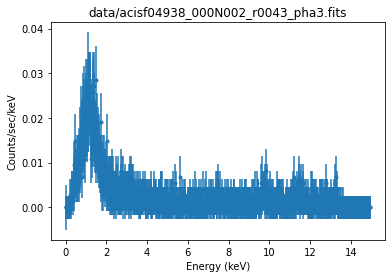

In [6]:
plot_data()

In [7]:
notice(0.5, 7)  # filter the data
group_counts(20, tabStops=~get_data().mask)  # group the data to 20 counts per bin

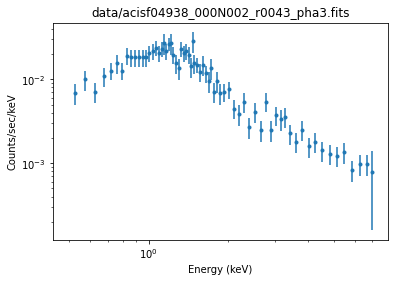

In [8]:
plot_data(xlog=True, ylog=True)

In [9]:
set_source(xsphabs.gal * powlaw1d.pl)
set_stat('chi2datavar')  # swap out how errors are calculated
fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 4.15159e+11
Final fit statistic   = 103.134 at function evaluation 266
Data points           = 67
Degrees of freedom    = 64
Probability [Q-value] = 0.00140194
Reduced statistic     = 1.61148
Change in statistic   = 4.15159e+11
   gal.nH         0.000567452  +/- 0.0361528   
   pl.gamma       1.76987      +/- 0.0862536   
   pl.ampl        7.50024e-05  +/- 5.77078e-06 


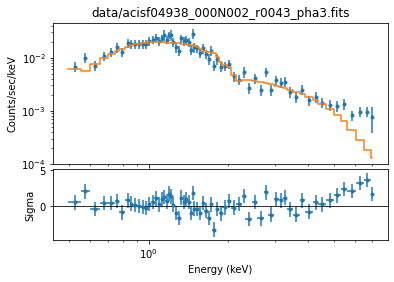

In [10]:
plot_fit_delchi(xlog=True, ylog=True)

So, the fit has an okay "reduced chi square" value, but you can see that above ~ 4 keV there is a systematic difference. I guess I should lok at the background (unfortunately there's currently no way to easily look at the background re-scaled to the source aperture):

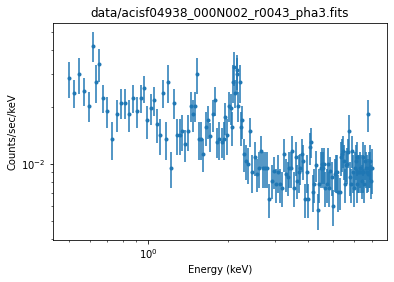

In [11]:
plot_bkg(xlog=True, ylog=True)

For now let's just subtract it (and don't listen to the statisticians who tell us, with good reason, that it's not a great thhing to do):

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 108.695
Final fit statistic   = 64.5108 at function evaluation 21
Data points           = 67
Degrees of freedom    = 64
Probability [Q-value] = 0.458602
Reduced statistic     = 1.00798
Change in statistic   = 44.184
   gal.nH         0.045911     +/- 0.0378437   
   pl.gamma       2.12096      +/- 0.128392    
   pl.ampl        8.00041e-05  +/- 8.72775e-06 


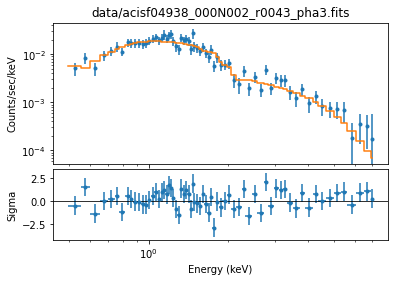

In [12]:
subtract()
fit()
plot_fit_delchi(xlog=True, ylog=True)

We can see that this gives a pretty good fit - that is we well describe the data with only three parameters:

In [13]:
calc_stat_info()

Dataset               = 1
Statistic             = chi2datavar
Fit statistic value   = 64.5108
Data points           = 67
Degrees of freedom    = 64
Probability [Q-value] = 0.458602
Reduced statistic     = 1.00798


That's unfortunate because I wanted a more-complex expression. Let's see what we can come up with:

In [14]:
set_source(gal * xsapec.gas + pl)

# An aside

Before we get into the fit, let's look at this expression: we have

- xsphabs.gal * xsapec.gas which is an XSPEC multiplicative model multiplying an XSPEC additive model
- powlaw1d.pl which is a Sherpa model

Note that we could have used `xspowerlaw.pl` and - other than a change in parameter names - get the same results.

In [15]:
total_model = get_source()

In [16]:
total_model  # rich interface

<BinaryOpModel model instance '((xsphabs.gal * xsapec.gas) + powlaw1d.pl)'>

In [17]:
repr(total_model)  # this is what you'd see in ipython

"<BinaryOpModel model instance '((xsphabs.gal * xsapec.gas) + powlaw1d.pl)'>"

If you really want to you can deconstruct this to get at the sub-expressions and individual components **but** you're generally-off better doing it manually (as we do below).

We can also look at the individual model components:

In [18]:
type(gal)

sherpa.astro.xspec.XSphabs

In [19]:
type(gas)

sherpa.astro.xspec.XSapec

In [20]:
type(pl)

sherpa.models.basic.PowLaw1D

We can identify whether a model is a multiplicative versus additive model from XSPEC using a variety of methods (they derive from `XSMultiplicativeModel` or `XSAdditiveModel`), but the easiest way is to check if it ends in a `norm` parameter (if so, it's additive, if not multiplicative):

In [21]:
gal.__class__.__mro__

(sherpa.astro.xspec.XSphabs,
 sherpa.astro.xspec.XSMultiplicativeModel,
 sherpa.astro.xspec.XSModel,
 sherpa.models.model.RegriddableModel1D,
 sherpa.models.model.RegriddableModel,
 sherpa.models.model.ArithmeticModel,
 sherpa.models.model.Model,
 sherpa.utils.NoNewAttributesAfterInit,
 object)

In [22]:
gas.__class__.__mro__

(sherpa.astro.xspec.XSapec,
 sherpa.astro.xspec.XSAdditiveModel,
 sherpa.astro.xspec.XSModel,
 sherpa.models.model.RegriddableModel1D,
 sherpa.models.model.RegriddableModel,
 sherpa.models.model.ArithmeticModel,
 sherpa.models.model.Model,
 sherpa.utils.NoNewAttributesAfterInit,
 object)

In [23]:
hasattr(gal, "norm")

False

In [24]:
hasattr(gas, "norm")

True

For Sherpa models the hierarchy is slightly different:

In [25]:
pl.__class__.__mro__

(sherpa.models.basic.PowLaw1D,
 sherpa.models.model.RegriddableModel1D,
 sherpa.models.model.RegriddableModel,
 sherpa.models.model.ArithmeticModel,
 sherpa.models.model.Model,
 sherpa.utils.NoNewAttributesAfterInit,
 object)

# An aside to the Aside

When you use the syntax `<model name>.<some random string>` then Sherpa, through the power of G̶r̶a̶y̶s̶k̶u̶l̶l̶ Python, will create a variable named `<some random string>` and set it to an instance of the model (if the model already exists it doesn't change things). This is why I could say

    set_source(gal * xsapec.gas + pl)
    
above: we re-use the existing `gal` and `pl` model instances and create a new one `gas`, which represents the XSPEC apec model.

If you want to you can hide this magic (whihc will make Cringer sad, to over-use the joke) you can explicitly create model instances and then use them in an expression:

In [26]:
create_model_component('xsphabs', 'gal2')  # note this creates the gal2 variable as well as returning it

Component,Parameter,Thawed,Value,Min,Max,Units
gal2,nH,,1.0,0.0,100000.0,10^22 atoms / cm^2


In [27]:
gal2

Component,Parameter,Thawed,Value,Min,Max,Units
gal2,nH,,1.0,0.0,100000.0,10^22 atoms / cm^2


In [28]:
create_model_component('xsapec', 'gas2')

<XSapec model instance 'xsapec.gas2'>

In [29]:
create_model_component('powlaw1d', 'pl2')

<PowLaw1D model instance 'powlaw1d.pl2'>

We can see a list of model components we have created:

In [30]:
list_model_components()

['gal', 'gal2', 'gas', 'gas2', 'pl', 'pl2']

I would say let's clean up, removing these components - as we have the `delete_model_component` call, but this currently doesn't work for reasons I haven't had time to dig into (follow along what fun there is at https://github.com/sherpa/sherpa/issues/16).

# Back to the fit

In [31]:
print(gas)

xsapec.gas
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   gas.kT       thawed            1        0.008           64        keV
   gas.Abundanc frozen            1            0            5           
   gas.redshift frozen            0       -0.999           10           
   gas.norm     thawed            1            0        1e+24           


In [32]:
gas.abundanc = 0.3  # pretend it's a galaxy cluster
thaw(gas.abundanc)  # you can say gal.abundanc.thaw()

gal.nh = 0.05
gal.nh.freeze()     # you can say freeze(gal.nh)

In [33]:
fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 4.28353e+10
Final fit statistic   = 61.0216 at function evaluation 332
Data points           = 67
Degrees of freedom    = 62
Probability [Q-value] = 0.511304
Reduced statistic     = 0.984219
Change in statistic   = 4.28353e+10
   gas.kT         1.01594      +/- 0.189523    
   gas.Abundanc   0            +/- 0.00974826  
   gas.norm       0.00037714   +/- 0.000106107 
   pl.gamma       0.978649     +/- 0.742772    
   pl.ampl        1.53734e-05  +/- 1.75568e-05 


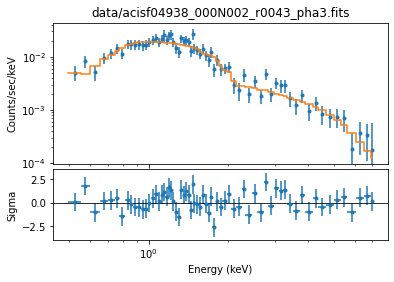

In [34]:
plot_fit_delchi(xlog=True, ylog=True)

So, the question is how can I see what the two components look like? Well, we can use [plot_source_component](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot_source_component.html) and [plot_model_component](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot_model_component.html).

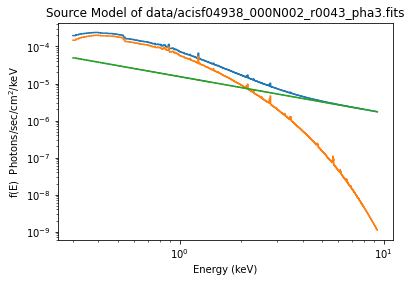

In [35]:
plot_source(xlog=True, ylog=True)
plot_source_component(gal * gas, overplot=True)
plot_source_component(pl, overplot=True)

Using `plot_model_component` is a bit-more complex because we need to add in the instrument response (this step **will not** be needed in CIAO 4.14, but that's only available in mid-December of this year, so it doesn't help us):

In [36]:
rsp = get_response()  # this contains the ARF, RMF, and exposure time terms

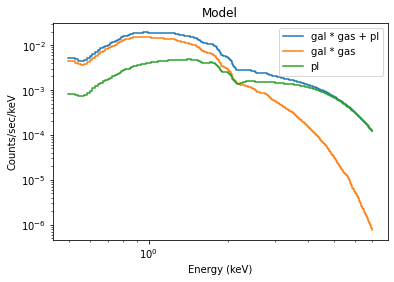

In [37]:
plot_model(xlog=True, ylog=True)
plot_model_component(rsp(gal * gas), overplot=True)
plot_model_component(rsp(pl), overplot=True)

# Let's add on a legend
#
plt.legend(['gal * gas + pl', 'gal * gas', 'pl']);

We can even see how much difference the absorption makes (which if you guessed "not a lot" then have a virtual cookie):

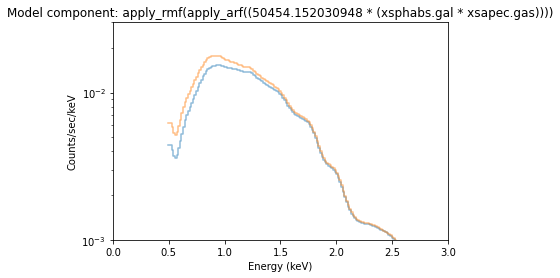

In [38]:
plot_model_component(rsp(gal * gas), ylog=True, alpha=0.5)
plot_model_component(rsp(gas), overplot=True, alpha=0.5)

plt.xlim(0, 3)
plt.ylim(1e-3, 3e-2);

For reference, we can see what the ARF looks like with [plot_arf](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot_arf.html) but we don't have any easy way to visualize a RMF (since it's a 2D matrix) - however, for users of Jupyter notebook we can get some idea as the `get_rmf()` call will return an object which displays a plot showing the response of the RMF for 5 mono-chromatic energies:

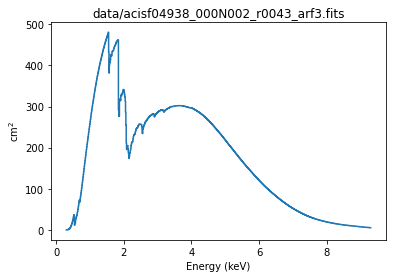

In [39]:
plot_arf()

In [40]:
get_arf()  # use rich interface

<DataARF data set instance 'data/acisf04938_000N002_r0043_arf3.fits'>

Find your favorite instrument scientist to explain to you the escape peaks and secondary features here (and it helps explain why we don't just invert the RMF matrix but go through the forward-folding exercise in Sherpa):

In [41]:
get_rmf()  # use rich interface

<DataRMF data set instance 'data/acisf04938_000N002_r0043_rmf3.fits'>

# Is this automated in Sherpa?

There is unfortunately no existing code which will split up a model expression into it's components: you have to do this on your own. We may add support for this to Sherpa (a user community that demand this feature is one way to go about this...).

# Where else can we use model components?

The main part of Sherpa that allows you to specify a subset of the full model expression is in calculating model fluxes: there's a very-interesting$\dagger$ notebook on the CIAO pages describing this at https://cxc.cfa.harvard.edu/ciao/guides/sherpa-flux.html which I can steal a bit from here:

---

$\dagger$ - although I may be a teensy-bit biased as I wrote it

In [42]:
# ensure we have a good fit
fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 61.0216
Final fit statistic   = 60.9901 at function evaluation 321
Data points           = 67
Degrees of freedom    = 62
Probability [Q-value] = 0.512443
Reduced statistic     = 0.983711
Change in statistic   = 0.0314779
   gas.kT         1.03242      +/- 0.189054    
   gas.Abundanc   3.6315e-06   +/- 0.0097521   
   gas.norm       0.000374566  +/- 0.000106277 
   pl.gamma       0.9772       +/- 0.745095    
   pl.ampl        1.52031e-05  +/- 1.76022e-05 


In [43]:
help(calc_energy_flux)

Help on function calc_energy_flux in module sherpa.astro.ui:

calc_energy_flux(lo=None, hi=None, id=None, bkg_id=None, model=None)
    Integrate the unconvolved source model over a pass band.
    
    Calculate the integral of E * S(E) over a pass band, where E
    is the energy of the bin and S(E) the spectral model evaluated
    for that bin (that is, the model without any instrumental
    responses applied to it).
    
    .. versionchanged:: 4.12.1
       The model parameter was added.
    
    Parameters
    ----------
    lo, hi : number, optional
       If both are None or both are set then calculate the flux
       over the given band. If only one is set then calculate
       the flux density at that point. The units for `lo` and `hi`
       are given by the current analysis setting.
    id : int or str, optional
       Use the source expression associated with this data set. If
       not given then the default identifier is used, as returned
       by ``get_default_id``.
    

In [44]:
fabs = calc_energy_flux(lo=0.5, hi=7, model=gal * gas)

In [45]:
funabs = calc_energy_flux(lo=0.5, hi=7, model=gas)

So, the absorbed and unabsorbed fluxes for the apec component is (units are `erg cm$^{-2}$ s$^{-1}`):

In [46]:
print(f"Absorbed flux   = {fabs:.3e} erg/cm^2/s")
print(f"Unabsobred flux = {funabs:.3e} erg/cm^2/s")

Absorbed flux   = 1.426e-13 erg/cm^2/s
Unabsobred flux = 1.636e-13 erg/cm^2/s


There's a lot more we could do, such as determine errors, but for that you'll have to read https://cxc.cfa.harvard.edu/ciao/guides/sherpa-flux.html